In [10]:
import sys
import os

# 设置运行路径
sys.path.append(os.path.abspath('../../'))

import math
import numpy as np
from algorithm.sum_dp_module import SumDP
from algorithm.laplace_module import LaplaceMechanism
from algorithm.error_evaluation.SumDP_eva import SumDPExperiment
from algorithm.error_evaluation.laplace_eva import LaplaceExperiment
import pandas as pd

In [31]:
import os

# 加载数据集
base_path = os.path.abspath(os.path.join('..', '..', 'datasets'))
loan_df = pd.read_csv(os.path.join(base_path, 'loan_data.csv'))
insurance_df = pd.read_csv(os.path.join(base_path, 'insurance.csv'))
students_df = pd.read_csv(os.path.join(base_path, 'StudentsPerformance.csv'))

# 展示每个数据集前几行
print("Loan Dataset:")
print(loan_df.head())

print("\nInsurance Dataset:")
print(insurance_df.head())

print("\nStudents Performance Dataset:")
print(students_df.head())

# 提取需要的列并处理为整数列表
loan_data = loan_df['LoanAmount'].dropna().astype(int).tolist()
insurance_data = insurance_df['charges'].dropna().astype(int).tolist()
students_data = students_df['math score'].dropna().astype(int).tolist()

# 打印一下前几个数值，确认没问题
print("LoanAmount sample:", loan_data[:5])
print("Charges sample:", insurance_data[:5])
print("Math score sample:", students_data[:5])



datasets = {
    "loan": loan_data,
    "insurance": insurance_data,
    "students": students_data
}

print(max(loan_data))
print(max(insurance_data))
print(max(students_data))

Loan Dataset:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001003   Male     Yes          1      Graduate            No   
1  LP001005   Male     Yes          0      Graduate           Yes   
2  LP001006   Male     Yes          0  Not Graduate            No   
3  LP001008   Male      No          0      Graduate            No   
4  LP001013   Male     Yes          0  Not Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4583             1508.0       128.0             360.0   
1             3000                0.0        66.0             360.0   
2             2583             2358.0       120.0             360.0   
3             6000                0.0       141.0             360.0   
4             2333             1516.0        95.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Rural           N  
1             1.0         Urban           Y  
2     

In [32]:
# 差分隐私参数设置
epsilons = [0.2, 0.5, 0.8, 1.0, 1.2, 2, 3, 5]        # 隐私预算
beta = 1e-5        # 概率参数（通常设置为 1e-5）
# n_trials is 1000 in default fun            
# upper bound 设置
U_loan = 512       # 数据上界，取大于等于 max(LoanAmount)
U_charge = 2**18   # 数据上界，医疗费用最大值
U_math = 300       # 学生成绩在 0~100 内

datasets_U = {
    "loan": U_loan,
    "insurance": U_charge,
    "students": U_math
}

results = []

# 遍历每个数据集
for name, data in datasets.items():
    max_val = max(data)
    U = datasets_U[name]
    clipped_data = [min(max(int(x), 0), U) for x in data]
    true_sum = sum(clipped_data)

    for epsilon in epsilons:
        # 初始化机制
        sumdp_instance = SumDP(epsilon=epsilon, beta=beta, U=U)
        laplace_instance = LaplaceMechanism(epsilon=epsilon, sensitivity=U)

        # 初始化评估器
        sumdp_eval = SumDPExperiment(sumdp_instance, clipped_data)
        laplace_eval = LaplaceExperiment(laplace_instance, clipped_data)

        # 执行实验
        sumdp_mean = sumdp_eval.run_experiment()
        laplace_mean= laplace_eval.run_experiment()

        # 保存结果
        results.append({
            'Dataset': name,
            'Epsilon': epsilon,
            'Max(D)': max_val,
            'U': U,
            'True Sum': true_sum,
            'SumDP Error': round(sumdp_mean, 2),
            'Laplace Error': round(laplace_mean, 2),
            'SumDP Bound': round(sumdp_eval.theoretical_error_bound(), 2),
            'Laplace Bound': round(laplace_eval.theoretical_error_bound(beta), 2)
        })


In [33]:
df_results = pd.DataFrame(results)
print(df_results)

      Dataset  Epsilon  Max(D)       U  True Sum  SumDP Error  Laplace Error  \
0        loan      0.2     150     512     40000     11553.42        2423.78   
1        loan      0.5     150     512     40000       776.68        1020.17   
2        loan      0.8     150     512     40000       392.80         636.95   
3        loan      1.0     150     512     40000       307.77         510.52   
4        loan      1.2     150     512     40000       266.11         409.36   
5        loan      2.0     150     512     40000       151.92         258.74   
6        loan      3.0     150     512     40000       100.36         161.75   
7        loan      5.0     150     512     40000        64.85          98.14   
8   insurance      0.2   63770  262144  17755165   4433363.09     1337100.22   
9   insurance      0.5   63770  262144  17755165    154533.95      516424.95   
10  insurance      0.8   63770  262144  17755165     97072.29      344048.42   
11  insurance      1.0   63770  262144  

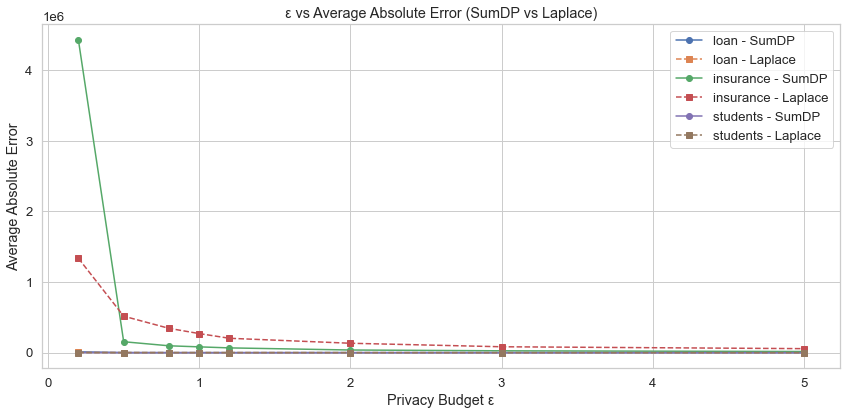

In [34]:
import matplotlib.pyplot as plt

# 折叠数据
datasets = df_results["Dataset"].unique()
epsilons = sorted(df_results["Epsilon"].unique())

plt.figure(figsize=(12, 6))

for dataset in datasets:
    df_subset = df_results[df_results["Dataset"] == dataset]
    
    sumdp_y = df_subset["SumDP Error"].tolist()
    laplace_y = df_subset["Laplace Error"].tolist()

    plt.plot(epsilons, sumdp_y, marker='o', label=f"{dataset} - SumDP")
    plt.plot(epsilons, laplace_y, marker='s', linestyle='--', label=f"{dataset} - Laplace")

plt.title("ε vs Average Absolute Error (SumDP vs Laplace)")
plt.xlabel("Privacy Budget ε")
plt.ylabel("Average Absolute Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



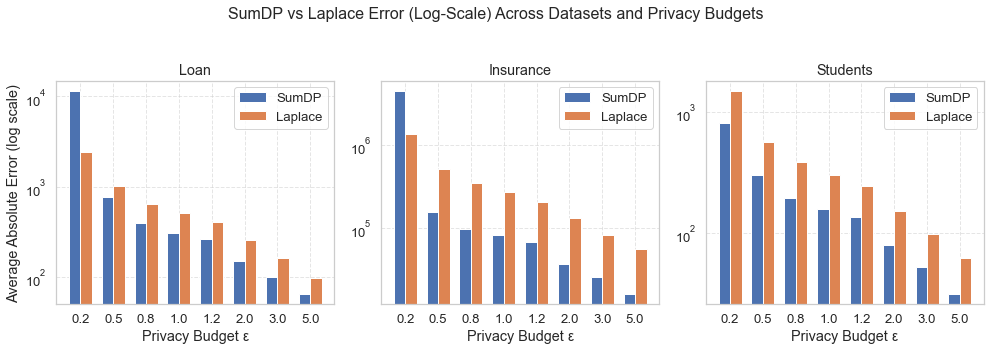

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df =  df_results

# 提取唯一的 ε 和数据集名称
epsilons = sorted(df["Epsilon"].unique())
datasets = df["Dataset"].unique()

# 颜色设置
colors = {
    "SumDP": "#4C72B0",      # 蓝色
    "Laplace": "#DD8452"     # 橙色
}

# 绘图
fig, axs = plt.subplots(1, len(datasets), figsize=(14, 5), sharey=False)
bar_width = 0.35
x = np.arange(len(epsilons))

for i, dataset in enumerate(datasets):
    ax = axs[i]
    df_subset = df[df["Dataset"] == dataset].sort_values("Epsilon")

    sumdp_errors = df_subset["SumDP Error"].values
    laplace_errors = df_subset["Laplace Error"].values

    ax.bar(x - bar_width/2, sumdp_errors, width=bar_width, label="SumDP", color=colors["SumDP"])
    ax.bar(x + bar_width/2, laplace_errors, width=bar_width, label="Laplace", color=colors["Laplace"])

    ax.set_title(dataset.capitalize())
    ax.set_xticks(x)
    ax.set_xticklabels(epsilons)
    ax.set_xlabel("Privacy Budget ε")
    ax.set_yscale("log")  
    if i == 0:
        ax.set_ylabel("Average Absolute Error (log scale)")

    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.suptitle("SumDP vs Laplace Error (Log-Scale) Across Datasets and Privacy Budgets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


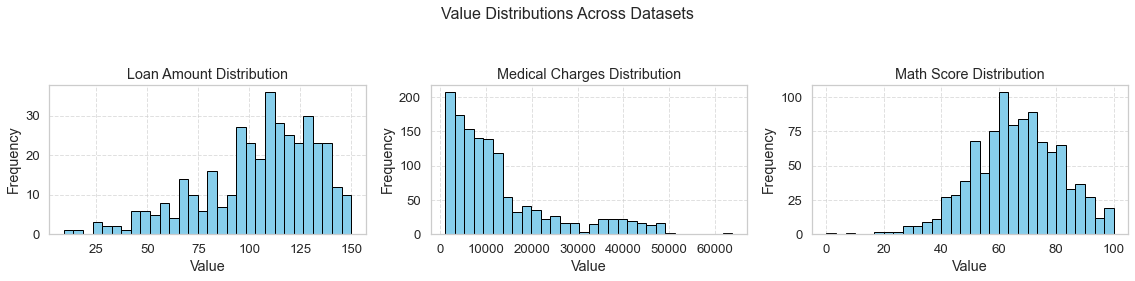

In [36]:


# 提取用于可视化的数值列（根据你的数据列名修改）
datasets = {
    "Loan Amount": loan_df["LoanAmount"].dropna().tolist(),
    "Medical Charges": insurance_df["charges"].dropna().tolist(),
    "Math Score": students_df["math score"].dropna().tolist()
}

# 多个子图展示每个数据集的值分布
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=False)

for ax, (title, values) in zip(axs, datasets.items()):
    ax.hist(values, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f"{title} Distribution")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Value Distributions Across Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
